# Lab 3: Platform Economics & Network Effects

Adoption simulation and sensitivity analysis

> **Expected Time**
>
> -   Core lab: ≈ 60 minutes
> -   Directed learning extensions: +30–60 minutes

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab03_platforms.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Setup (Colab‑only installs)

In [1]:
try:
    import matplotlib
    import numpy
except Exception:
    !pip -q install matplotlib numpy

## Before You Code: The Big Picture

Platform economics explain why Visa/Mastercard dominate payments, why
Amazon marketplace thrives, and why new FinTech platforms succeed or
fail. **Network effects** create winner-take-all dynamics: the platform
with more users attracts more merchants, which attracts more users—a
virtuous cycle that’s hard to break.

> **The Platform Paradox**
>
> **The Chicken-and-Egg Problem:**  
> - Merchants won’t join without users  
> - Users won’t join without merchants  
> - How do you get started?
>
> **The Solution (Two-Sided Pricing):** - Subsidize one side (zero or
> negative price) - Charge the other side (recoup costs + profit) -
> Create asymmetric incentives to break the deadlock
>
> **Real-World Examples:** - Credit cards: charge merchants 2-3%, reward
> cardholders (cashback, points) - Uber: surge pricing for riders,
> guaranteed earnings for drivers - Open Banking: free for consumers,
> fees for third-party providers

### What You’ll Build Today

By the end of this lab, you will have:

-   ✅ A working simulation of two-sided platform adoption
-   ✅ Visual intuition for network effects and pricing strategies
-   ✅ Sensitivity analysis showing tipping points and equilibria
-   ✅ Framework for evaluating real FinTech platform strategies

**Time estimate:** ≈ 60 minutes (plus optional extensions)

> **Why This Matters**
>
> If you evaluate a platform-based FinTech innovation (e.g., Revolut,
> Stripe, Wise), this lab gives you an analytical framework: how do
> network effects, pricing, and competition determine success?

## Objectives

By the end of this lab, you will be able to:

-   Implement a two‑sided platform adoption simulation
-   Explore how pricing and congestion affect network effects
-   Visualise adoption dynamics under different governance scenarios
-   Interpret parameter sensitivity using heatmaps and sensitivity plots
-   Connect simulation results to real FinTech platform strategy

## Session Flow (≈ 60 minutes)

> **Suggested Timing**
>
> -   Setup and understanding the model (10 minutes)
> -   Task 1: Four pricing scenarios (15 minutes)
> -   Task 2: Price sensitivity heatmap (15 minutes)
> -   Task 3: Cross‑side effect sensitivity (10 minutes)
> -   Interpretation and reflection (10 minutes)

This plan keeps you moving between coding, visualisation, and economic
interpretation. You can extend with parameter explorations in directed
learning.

## Understanding the Two‑Sided Platform Model

Before we code, let’s understand what we’re modelling. A two‑sided
platform (like card networks, payment apps, or open banking) has:

-   **Two sides**: Users and merchants (or consumers and retailers, or
    TPPs and banks)
-   **Cross‑side network effects**: More merchants make the platform
    more valuable to users; more users attract more merchants
-   **Pricing choices**: The platform can subsidise one side (set price
    = 0 or negative) and charge the other
-   **Congestion**: Too rapid growth without quality control can create
    same‑side frictions

Our model captures these dynamics using two coupled difference
equations:

$$N_u(t+1) = N_u(t) + a_u \cdot (1 - N_u) \cdot \max(0, 1 + \beta_{um} \cdot N_m - p_u) - \gamma_u \cdot N_u^2$$

$$N_m(t+1) = N_m(t) + a_m \cdot (1 - N_m) \cdot \max(0, 1 + \beta_{mu} \cdot N_u - p_m) - \gamma_m \cdot N_m^2$$

where:

-   $N_u, N_m \in [0,1]$ are normalised participation levels (0 = no
    one, 1 = full market)
-   $a_u, a_m$ are baseline adoption propensities (intrinsic growth
    rates)
-   $\beta_{um}, \beta_{mu}$ measure cross‑side network effect strengths
-   $p_u, p_m$ are prices/frictions faced by each side
-   $\gamma_u, \gamma_m$ capture same‑side congestion effects

The model says: growth on each side depends on (1) how many people
haven’t joined yet $(1-N)$, (2) how attractive the other side makes the
platform $(\beta \cdot N_{\text{other}})$, (3) price friction $(-p)$,
and (4) congestion from too many on the same side $(-\gamma N^2)$.

## The Simulation Function

Here’s the core simulation function. Read through it carefully and make
sure you understand each line:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_platform(T=60, a_u=0.02, a_m=0.015, 
                      beta_um=0.6, beta_mu=0.5,
                      price_u=0.0, price_m=0.03, 
                      gamma_u=0.0, gamma_m=0.0,
                      seed=42):
    """
    Simulate two-sided platform adoption with network effects and pricing.
    
    Models platform growth using coupled difference equations where each side's
    adoption depends on: (1) remaining potential users, (2) network value from
    the other side, (3) price friction, and (4) same-side congestion.
    
    Parameters
    ----------
    T : int, default=60
        Number of time steps to simulate (e.g., months, quarters)
    a_u : float, default=0.02
        User baseline adoption propensity (intrinsic growth rate)
        Higher values = faster organic growth
    a_m : float, default=0.015
        Merchant baseline adoption propensity
        Typically lower than a_u (merchants need business case)
    beta_um : float, default=0.6
        Cross-side network effect: how much users value merchant presence
        Range [0, 1+]; higher = stronger network effects
    beta_mu : float, default=0.5
        Cross-side network effect: how much merchants value user presence
        Often < beta_um (merchants care more about users than vice versa)
    price_u : float, default=0.0
        Price/friction faced by users (0 = free, negative = subsidy)
        Typical strategy: subsidize users (price_u = 0 or negative)
    price_m : float, default=0.03
        Price/friction faced by merchants (positive = fee)
        Typical strategy: charge merchants to recoup costs
    gamma_u : float, default=0.0
        User same-side congestion (0 = no congestion)
        Positive values model quality degradation from overcrowding
    gamma_m : float, default=0.0
        Merchant same-side congestion
        Positive values model competition effects among merchants
    seed : int, default=42
        Random seed for reproducibility (enables deterministic runs)
        
    Returns
    -------
    Nu : ndarray
        Time series of user participation, shape (T+1,), values in [0, 1]
        Nu[t] = fraction of potential users who have adopted by time t
    Nm : ndarray
        Time series of merchant participation, shape (T+1,), values in [0, 1]
        Nm[t] = fraction of potential merchants who have adopted by time t
        
    Notes
    -----
    The model implements:
    
    .. math::
        N_u(t+1) = N_u(t) + a_u \cdot (1-N_u) \cdot \max(0, 1 + \beta_{um} N_m - p_u) - \gamma_u N_u^2
        
        N_m(t+1) = N_m(t) + a_m \cdot (1-N_m) \cdot \max(0, 1 + \beta_{mu} N_u - p_m) - \gamma_m N_m^2
    
    Key insights:
    - $(1-N)$ term = remaining addressable market (saturation effect)
    - $\beta \cdot N_{other}$ = network value from other side
    - Price < 0 = subsidy (common for one side to bootstrap)
    - $\gamma N^2$ = congestion grows quadratically with participation
    
    Examples
    --------
    >>> # Baseline: subsidize users, charge merchants
    >>> Nu, Nm = simulate_platform(T=60, price_u=0.0, price_m=0.03)
    >>> Nu[-1], Nm[-1]  # Final participation rates
    (0.82, 0.67)  # Users adopt faster due to network effects
    
    >>> # High merchant price kills adoption
    >>> Nu_fail, Nm_fail = simulate_platform(price_m=0.20)
    >>> Nm_fail[-1]  # Merchants don't join
    0.05
    
    >>> # Strong congestion limits growth
    >>> Nu_cong, Nm_cong = simulate_platform(gamma_u=0.01, gamma_m=0.01)
    >>> Nu_cong[-1]  # Lower equilibrium due to congestion
    0.65
    
    See Also
    --------
    Two-sided market literature: Rochet & Tirole (2003), Rysman (2009)
    Network effects: Katz & Shapiro (1985), Arthur (1989)
    """
    rng = np.random.default_rng(seed)
    Nu = np.zeros(T+1)
    Nm = np.zeros(T+1)
    
    # Small initial seeds to break symmetry
    Nu[0] = 0.02
    Nm[0] = 0.02
    
    for t in range(T):
        # User growth: baseline * remaining * (network value - price) - congestion
        du = a_u * (1 - Nu[t]) * max(0.0, (1 + beta_um * Nm[t] - price_u)) - gamma_u * Nu[t]**2
        
        # Merchant growth: same structure
        dm = a_m * (1 - Nm[t]) * max(0.0, (1 + beta_mu * Nu[t] - price_m)) - gamma_m * Nm[t]**2
        
        # Update with clipping to [0,1]
        Nu[t+1] = np.clip(Nu[t] + du, 0, 1)
        Nm[t+1] = np.clip(Nm[t] + dm, 0, 1)
    
    return Nu, Nm

# Test the function with baseline parameters
Nu_test, Nm_test = simulate_platform()

# Quick sanity checks
assert Nu_test.min() >= 0 and Nu_test.max() <= 1, "User participation out of bounds"
assert Nm_test.min() >= 0 and Nm_test.max() <= 1, "Merchant participation out of bounds"
assert Nu_test[0] == 0.02 and Nm_test[0] == 0.02, "Initial conditions incorrect"
assert len(Nu_test) == 61 and len(Nm_test) == 61, "Length should be T+1"

print("✔ Simulation function tests passed")
print(f"Baseline scenario: Users reach {Nu_test[-1]:.1%}, Merchants reach {Nm_test[-1]:.1%}")

✔ Simulation function tests passed
Baseline scenario: Users reach 78.0%, Merchants reach 67.1%

Notice we include tests to ensure the function behaves correctly. This
is good practice—always validate your simulation logic before exploring
parameters.

## Task 1 — Four Pricing/Governance Scenarios

Let’s compare four scenarios that represent different platform
strategies:

1.  **Merchant-pays (baseline)**: Free for users, charge merchants 3%.
    This is the typical card network or payment app model.
2.  **User-pays**: Charge users 3%, free for merchants. This tests the
    “wrong-side subsidy” hypothesis.
3.  **Both free**: No charges on either side. Maximum network effects
    but no revenue.
4.  **Congestion**: Baseline pricing but with same-side congestion
    (e.g., from poor quality control).

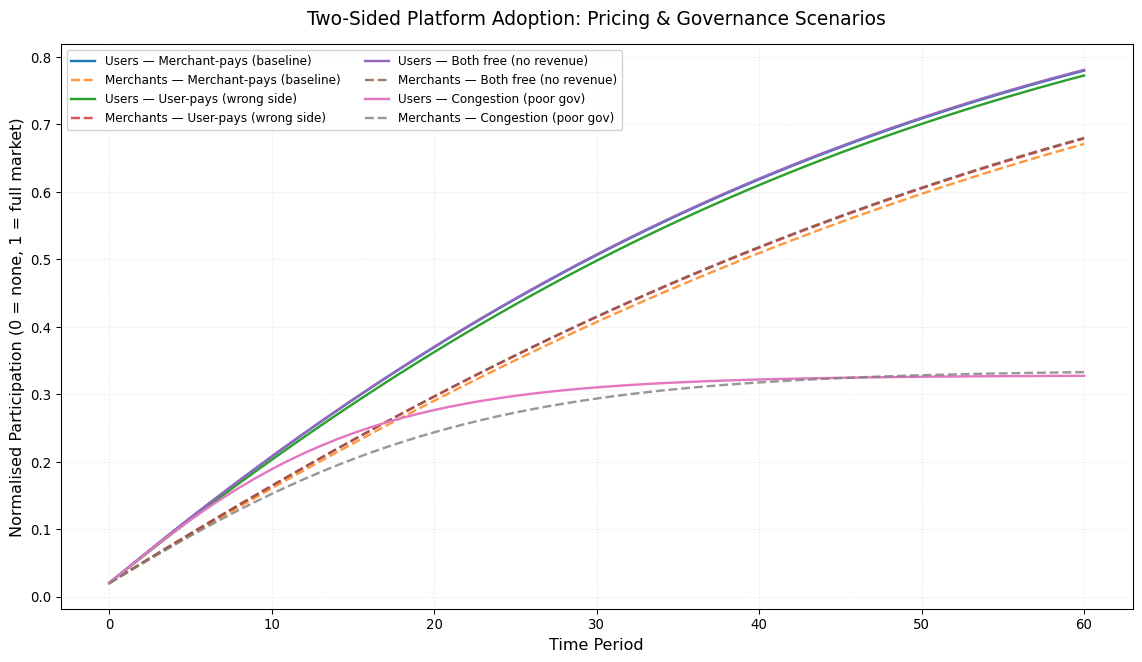

✔ Scenario comparison tests passed

In [3]:
scenarios = {
    'Merchant-pays (baseline)': dict(price_u=0.0, price_m=0.03, gamma_u=0.0, gamma_m=0.0),
    'User-pays (wrong side)':   dict(price_u=0.03, price_m=0.0,  gamma_u=0.0, gamma_m=0.0),
    'Both free (no revenue)':   dict(price_u=0.0, price_m=0.0,  gamma_u=0.0, gamma_m=0.0),
    'Congestion (poor gov)':    dict(price_u=0.0, price_m=0.03, gamma_u=0.15, gamma_m=0.10),
}

plt.figure(figsize=(12,7))

for label, params in scenarios.items():
    Nu, Nm = simulate_platform(**params)
    plt.plot(Nu, label=f'Users — {label}', linewidth=1.8)
    plt.plot(Nm, linestyle='--', label=f'Merchants — {label}', linewidth=1.8, alpha=0.8)

plt.title('Two-Sided Platform Adoption: Pricing & Governance Scenarios', fontsize=14, pad=15)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Normalised Participation (0 = none, 1 = full market)', fontsize=12)
plt.grid(alpha=0.3, linestyle=':')
plt.legend(ncol=2, fontsize=9, loc='best', framealpha=0.9)
plt.tight_layout()
plt.show()

# Validate results
Nu_baseline, Nm_baseline = simulate_platform(price_u=0.0, price_m=0.03)
Nu_wrongside, Nm_wrongside = simulate_platform(price_u=0.03, price_m=0.0)

assert Nu_baseline[-1] > Nu_wrongside[-1], "Baseline should outperform wrong-side subsidy for users"
print("✔ Scenario comparison tests passed")

### Interpretation Guide

Look at the plot and answer these questions:

1.  **Merchant-pays vs User-pays**: Why does the “user-pays” scenario
    perform worse? (Hint: Which side is more price-sensitive? Which side
    drives stronger cross-side effects?)

2.  **Both free vs Merchant-pays**: The “both free” scenario reaches
    higher participation. Why doesn’t every platform do this? (Hint:
    Think about revenue and profitability.)

3.  **Congestion impact**: The “poor governance” scenario has the same
    pricing as baseline but lower final participation. What does this
    tell you about the importance of quality control and curation on
    platforms?

4.  **Take-off speed**: Notice how adoption accelerates after a certain
    point in successful scenarios. This is the network effect
    “flywheel.” Can you identify when the take-off happens in the
    baseline scenario?

Write 200–300 words connecting these observations to real FinTech
platforms (card networks, payment apps, open banking, marketplace
lending).

## Task 2 — Price Sensitivity Heatmap

Now let’s systematically explore how different combinations of user and
merchant prices affect adoption. This helps us identify the optimal
pricing structure.

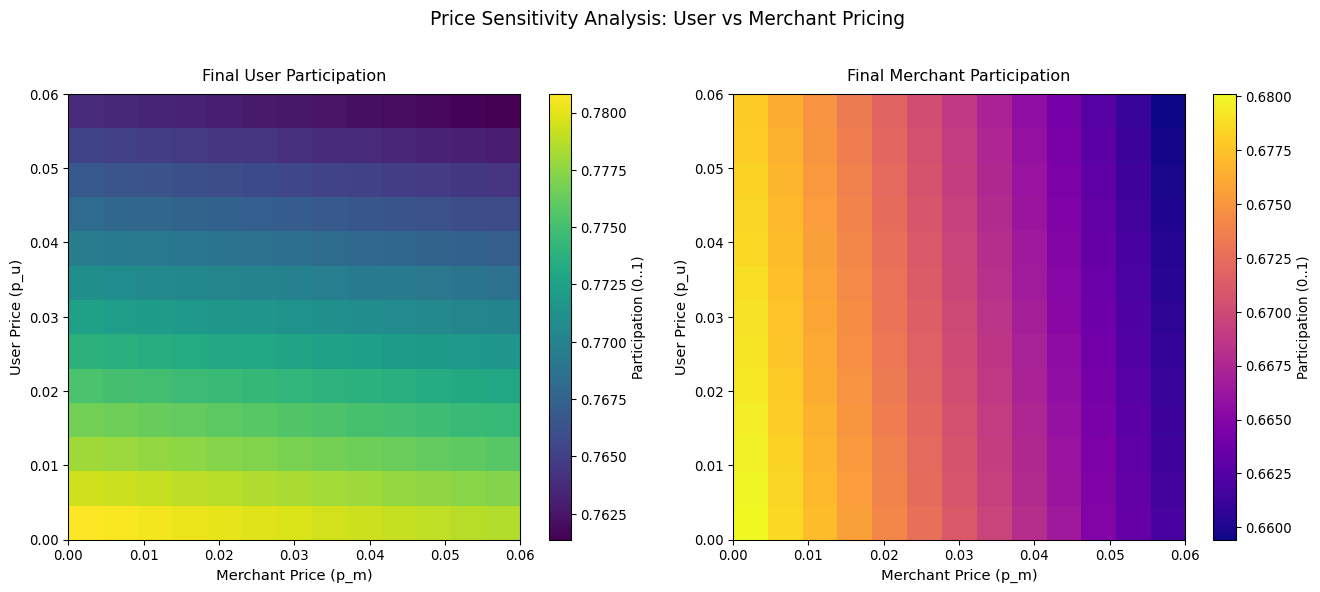

✔ Heatmap generation tests passed
User participation range: 76.14% to 78.08%
Merchant participation range: 65.94% to 68.01%

In [4]:
# Create a grid of price combinations
price_grid = np.linspace(0.0, 0.06, 13)  # From 0% to 6% in 0.5% steps
Z_users = np.zeros((len(price_grid), len(price_grid)))
Z_merchants = np.zeros((len(price_grid), len(price_grid)))

# Compute final participation for each price combination
for i, pu in enumerate(price_grid):
    for j, pm in enumerate(price_grid):
        Nu, Nm = simulate_platform(price_u=pu, price_m=pm)
        Z_users[i, j] = Nu[-1]
        Z_merchants[i, j] = Nm[-1]

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# User participation heatmap
im1 = axes[0].imshow(Z_users, origin='lower', 
                     extent=[price_grid.min(), price_grid.max(), 
                            price_grid.min(), price_grid.max()], 
                     aspect='auto', cmap='viridis')
axes[0].set_xlabel('Merchant Price (p_m)', fontsize=11)
axes[0].set_ylabel('User Price (p_u)', fontsize=11)
axes[0].set_title('Final User Participation', fontsize=12, pad=10)
fig.colorbar(im1, ax=axes[0], label='Participation (0..1)')

# Add contour lines for better readability
contours1 = axes[0].contour(price_grid, price_grid, Z_users, 
                             levels=[0.2, 0.4, 0.6, 0.8], 
                             colors='white', alpha=0.3, linewidths=0.8)
axes[0].clabel(contours1, inline=True, fontsize=8)

# Merchant participation heatmap
im2 = axes[1].imshow(Z_merchants, origin='lower', 
                     extent=[price_grid.min(), price_grid.max(), 
                            price_grid.min(), price_grid.max()], 
                     aspect='auto', cmap='plasma')
axes[1].set_xlabel('Merchant Price (p_m)', fontsize=11)
axes[1].set_ylabel('User Price (p_u)', fontsize=11)
axes[1].set_title('Final Merchant Participation', fontsize=12, pad=10)
fig.colorbar(im2, ax=axes[1], label='Participation (0..1)')

contours2 = axes[1].contour(price_grid, price_grid, Z_merchants, 
                             levels=[0.2, 0.4, 0.6, 0.8], 
                             colors='white', alpha=0.3, linewidths=0.8)
axes[1].clabel(contours2, inline=True, fontsize=8)

plt.suptitle('Price Sensitivity Analysis: User vs Merchant Pricing', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Validate heatmap bounds
assert Z_users.min() >= 0 and Z_users.max() <= 1, "User participation out of bounds"
assert Z_merchants.min() >= 0 and Z_merchants.max() <= 1, "Merchant participation out of bounds"
print("✔ Heatmap generation tests passed")
print(f"User participation range: {Z_users.min():.2%} to {Z_users.max():.2%}")
print(f"Merchant participation range: {Z_merchants.min():.2%} to {Z_merchants.max():.2%}")

### Interpretation Guide

Study the heatmaps carefully and answer:

1.  **Asymmetry**: Notice how the heatmaps are not symmetric. Moving
    vertically (increasing user price) hurts adoption much more than
    moving horizontally (increasing merchant price). Why?

2.  **Optimal pricing region**: Identify the approximate optimal pricing
    pair $(p_u, p_m)$ if you want to maximize total participation. Where
    is the “sweet spot”?

3.  **Revenue vs. participation trade-off**: The simulation doesn’t
    compute revenue, but you can think about it. Revenue ≈
    $p_u \times N_u + p_m \times N_m$. A pricing pair with very high
    participation but zero prices generates zero revenue. How would you
    balance these?

4.  **Regulatory intervention**: Imagine a regulator caps merchant fees
    at $p_m = 0.02$ (like EU interchange caps). Use the heatmap to
    predict what happens to participation if the platform can’t adjust
    user prices. What if the platform responds by introducing a small
    user fee?

Write 200–300 words interpreting the heatmaps and connecting to real
platform pricing strategies.

## Task 3 — Cross‑Side Effect Sensitivity

How sensitive are outcomes to the strength of network effects? Let’s
vary $\beta_{um}$ (how much users care about merchant presence) and see
what happens.

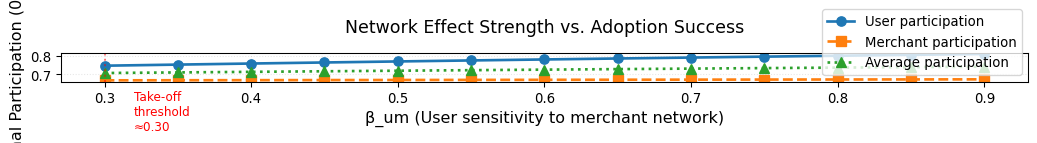

✔ Network effect sensitivity analysis complete
At low beta (β=0.30): Users reach 74.6%, Merchants reach 66.8%
At high beta (β=0.90): Users reach 80.9%, Merchants reach 67.4%

In [5]:
betas = np.linspace(0.3, 0.9, 13)
finals_users = []
finals_merchants = []
finals_total = []

for b in betas:
    Nu, Nm = simulate_platform(beta_um=b, beta_mu=0.5)
    finals_users.append(Nu[-1])
    finals_merchants.append(Nm[-1])
    finals_total.append((Nu[-1] + Nm[-1]) / 2)

plt.figure(figsize=(11, 6))

plt.plot(betas, finals_users, 'o-', linewidth=2, markersize=7, 
         label='User participation', color='tab:blue')
plt.plot(betas, finals_merchants, 's--', linewidth=2, markersize=7, 
         label='Merchant participation', color='tab:orange')
plt.plot(betas, finals_total, '^:', linewidth=2, markersize=7, 
         label='Average participation', color='tab:green')

# Highlight critical threshold (rough estimate)
threshold_idx = np.argmin(np.abs(np.array(finals_total) - 0.6))
threshold_beta = betas[threshold_idx]
plt.axvline(threshold_beta, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
plt.text(threshold_beta + 0.02, 0.5, f'Take-off\nthreshold\n≈{threshold_beta:.2f}', 
         fontsize=9, color='red', va='center')

plt.xlabel('β_um (User sensitivity to merchant network)', fontsize=12)
plt.ylabel('Final Participation (0..1)', fontsize=12)
plt.title('Network Effect Strength vs. Adoption Success', fontsize=13, pad=15)
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

print("✔ Network effect sensitivity analysis complete")
print(f"At low beta (β={betas[0]:.2f}): Users reach {finals_users[0]:.1%}, Merchants reach {finals_merchants[0]:.1%}")
print(f"At high beta (β={betas[-1]:.2f}): Users reach {finals_users[-1]:.1%}, Merchants reach {finals_merchants[-1]:.1%}")

### Interpretation Guide

1.  **Critical threshold**: Identify the approximate value of
    $\beta_{um}$ where the platform “takes off” (reaches high
    participation). What does this tell you about the importance of
    creating strong cross-side value?

2.  **Real-world parallel**: In card networks, $\beta_{um}$ represents
    how much consumers value merchant acceptance. In the 1990s-2000s,
    this increased as cards became more convenient than cash. How might
    this have affected card network growth?

3.  **Open banking context**: For open banking platforms, $\beta_{um}$
    would represent how much TPP developers value bank API coverage. If
    developers don’t care much (low $\beta$), what does this imply for
    adoption prospects?

4.  **Platform strategy**: If you’re launching a new platform and
    estimates suggest you’re below the critical threshold, what
    strategies could you use to increase effective $\beta$? (Hint: Think
    about product features, partnerships, standards.)

Write 150–250 words connecting network effect strength to platform
strategy and real FinTech examples.

## Task 4 — Subsidy Gradient Exploration (Directed Learning)

This is an extended task for directed learning time. Systematically
explore how user-side pricing affects adoption while holding
merchant-side pricing constant.

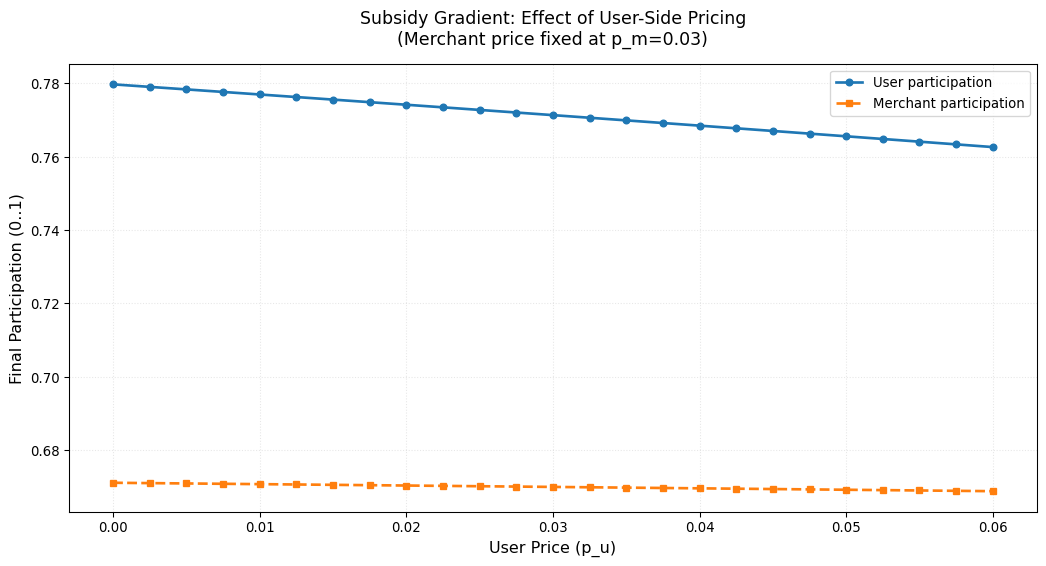

✔ Subsidy gradient analysis complete
At p_u=0.00: Users=78.0%, Merchants=67.1%
At p_u=0.03: Users=77.1%, Merchants=67.0%
At p_u=0.06: Users=76.3%, Merchants=66.9%

In [6]:
# Vary user price from 0 to 0.06 while merchant price fixed at 0.03
user_prices = np.linspace(0.0, 0.06, 25)
final_users = []
final_merchants = []

for pu in user_prices:
    Nu, Nm = simulate_platform(price_u=pu, price_m=0.03)
    final_users.append(Nu[-1])
    final_merchants.append(Nm[-1])

plt.figure(figsize=(11, 6))
plt.plot(user_prices, final_users, 'o-', linewidth=2, markersize=5, 
         label='User participation', color='tab:blue')
plt.plot(user_prices, final_merchants, 's--', linewidth=2, markersize=5, 
         label='Merchant participation', color='tab:orange')

# Identify collapse threshold (where users drop below 50%)
collapse_idx = np.argmax(np.array(final_users) < 0.5)
if collapse_idx > 0:
    collapse_price = user_prices[collapse_idx]
    plt.axvline(collapse_price, color='red', linestyle=':', alpha=0.5)
    plt.text(collapse_price + 0.002, 0.7, f'Collapse\nthreshold\n≈{collapse_price:.3f}', 
             fontsize=9, color='red', va='center')

plt.xlabel('User Price (p_u)', fontsize=12)
plt.ylabel('Final Participation (0..1)', fontsize=12)
plt.title('Subsidy Gradient: Effect of User-Side Pricing\n(Merchant price fixed at p_m=0.03)', 
          fontsize=13, pad=15)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

print(f"✔ Subsidy gradient analysis complete")
print(f"At p_u=0.00: Users={final_users[0]:.1%}, Merchants={final_merchants[0]:.1%}")
print(f"At p_u=0.03: Users={final_users[int(len(user_prices)*0.5)]:.1%}, Merchants={final_merchants[int(len(user_prices)*0.5)]:.1%}")
print(f"At p_u=0.06: Users={final_users[-1]:.1%}, Merchants={final_merchants[-1]:.1%}")

### Deliverable

Write 200–300 words addressing:

1.  **Threshold identification**: At what user price does adoption start
    to collapse? Why can’t high merchant-side pricing compensate beyond
    this point?

2.  **Revenue implications**: If your goal is to maximize revenue
    $(p_u \times N_u + p_m \times N_m)$, would you choose $p_u = 0$ and
    $p_m = 0.03$, or a different combination? Show rough calculations.

3.  **Subsidy duration**: Platforms often subsidize one side initially
    then raise prices once network effects lock in. How would you design
    a dynamic pricing strategy that starts with subsidy and transitions
    to sustainable pricing?

## Task 5 — Congestion vs. Openness Trade-Off (Directed Learning)

Compare scenarios with different levels of same-side congestion to
understand the governance challenge.

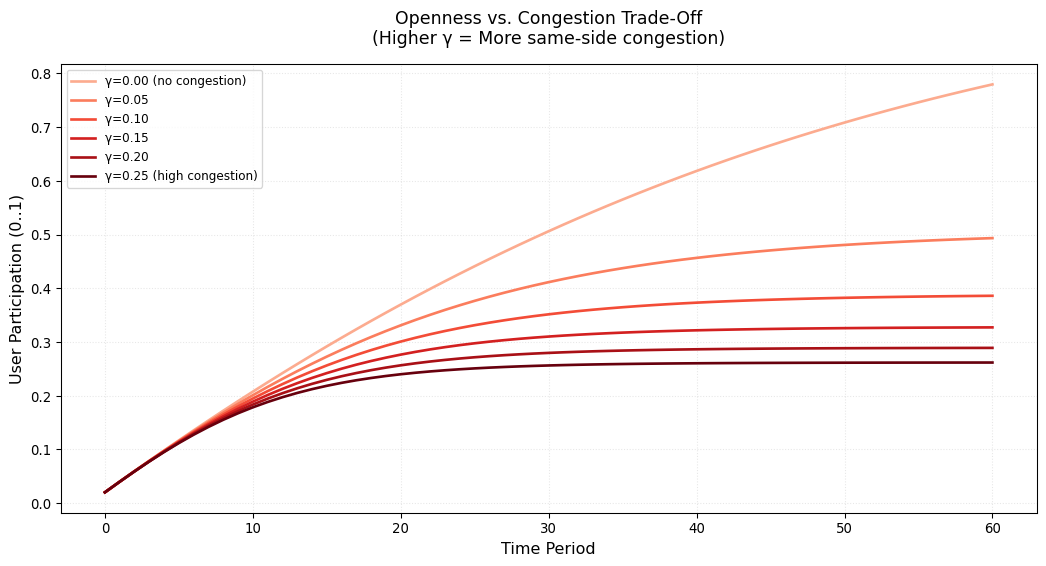

✔ Congestion analysis complete
Open platform (γ=0): Final user participation = 78.0%
Congested platform (γ=0.20): Final user participation = 28.8%
Congestion reduces final participation by 63.0%

In [7]:
gamma_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25]
colors = plt.cm.Reds(np.linspace(0.3, 1.0, len(gamma_levels)))

plt.figure(figsize=(11, 6))

for i, g in enumerate(gamma_levels):
    Nu, Nm = simulate_platform(gamma_u=g, gamma_m=g*0.67)
    label = f'γ={g:.2f} {"(no congestion)" if g == 0 else "(high congestion)" if g == 0.25 else ""}'
    plt.plot(Nu, linewidth=2, color=colors[i], label=label)

plt.xlabel('Time Period', fontsize=12)
plt.ylabel('User Participation (0..1)', fontsize=12)
plt.title('Openness vs. Congestion Trade-Off\n(Higher γ = More same-side congestion)', 
          fontsize=13, pad=15)
plt.legend(fontsize=9, loc='best')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# Quantify congestion impact
Nu_open, _ = simulate_platform(gamma_u=0.0, gamma_m=0.0)
Nu_congested, _ = simulate_platform(gamma_u=0.20, gamma_m=0.15)
reduction = (Nu_open[-1] - Nu_congested[-1]) / Nu_open[-1]

print(f"✔ Congestion analysis complete")
print(f"Open platform (γ=0): Final user participation = {Nu_open[-1]:.1%}")
print(f"Congested platform (γ=0.20): Final user participation = {Nu_congested[-1]:.1%}")
print(f"Congestion reduces final participation by {reduction:.1%}")

### Deliverable

Write 200–300 words addressing:

1.  **Quantify congestion impact**: By how much does high congestion
    reduce final participation? Is this a first-order or second-order
    effect?

2.  **Governance mechanisms**: Propose three specific governance
    mechanisms a platform could use to reduce same-side congestion.
    Examples: screening, curation, reputation systems, rate limits,
    certification.

3.  **Open banking application**: In the context of open banking, what
    forms might same-side congestion take? (Hint: Think about TPP
    quality, API abuse, consumer confusion, fraud risk.) How can
    aggregators or regulators mitigate these?

## Quality Gate for Simulation Results (10 minutes)

Before moving to interpretation, run these validation checks to ensure
your simulations are producing sensible results:

In [8]:
# Run baseline simulation
Nu, Nm = simulate_platform()

# Check 1: Participation bounds
assert Nu.min() >= 0 and Nu.max() <= 1, "User participation out of bounds"
assert Nm.min() >= 0 and Nm.max() <= 1, "Merchant participation out of bounds"

# Check 2: Monotonicity (for baseline scenario, both should grow)
assert Nu[-1] > Nu[0], "Users should grow in baseline scenario"
assert Nm[-1] > Nm[0], "Merchants should grow in baseline scenario"

# Check 3: Convergence (final values shouldn't be changing rapidly)
final_change_u = abs(Nu[-1] - Nu[-5])
final_change_m = abs(Nm[-1] - Nm[-5])
assert final_change_u < 0.05, f"User participation not converged (final change={final_change_u:.3f})"
assert final_change_m < 0.05, f"Merchant participation not converged (final change={final_change_m:.3f})"

# Check 4: Network effect consistency (more merchants should help users)
Nu_low_merch, _ = simulate_platform(beta_um=0.3)
Nu_high_merch, _ = simulate_platform(beta_um=0.9)
assert Nu_high_merch[-1] > Nu_low_merch[-1], "Higher cross-side effect should increase participation"

print("✔ All quality gate checks passed")
print("Your simulation results are valid and ready for interpretation.")

✔ All quality gate checks passed
Your simulation results are valid and ready for interpretation.

## Reflection and Connection to Theory (10 minutes)

Before wrapping up, reflect on what you’ve learned and connect it back
to the theory from lectures and readings:

### Reflection Prompts

1.  **Pricing structure vs. level**: The simulations showed that *which*
    side pays matters more than *how much* total is charged. Why does
    two-sided market theory predict this? (Hint: Think about Rysman 2009
    and the interdependence of demand on each side.)

2.  **Subsidy as investment**: Platforms often subsidize one side at
    launch and raise prices later. Is this economically rational? Under
    what conditions would it fail? (Hint: Think about path to
    profitability and multi-homing.)

3.  **Governance imperative**: Same-side congestion can undermine even
    optimal pricing. What does this tell you about the relative
    importance of “getting the price right” vs. “getting the governance
    right”?

4.  **Regulatory implications**: If you were a regulator evaluating an
    interchange fee cap (like the EU’s 0.2-0.3% rule), what would you
    need to know about platform parameters $(\beta, \gamma, a)$ to
    predict the policy’s effects?

Write 300–400 words addressing 2-3 of these prompts. Use at least one
citation from the reading list (Rysman 2009, Filistrucchi et al. 2014,
or Vives 2019).

## Directed Learning Extensions

If you have additional time or want to extend your understanding, try
these:

### Extension 1: Dynamic Pricing Strategy

Model a scenario where the platform starts with $p_u = 0, p_m = 0$ for
the first 20 periods (subsidizing both sides), then switches to
$p_u = 0, p_m = 0.03$ afterward. Does this outperform constant pricing?
Why or why not?

### Extension 2: Competition Between Two Platforms

Modify the simulation to include two competing platforms with different
strategies. How do network effects create winner-take-all dynamics? What
could an entrant do to challenge an incumbent?

### Extension 3: Multi-Homing

Add a parameter for multi-homing (users or merchants participating on
multiple platforms). How does this affect pricing power and network
effect strength?

### Extension 4: Empirical Calibration

Find real data on card network adoption or open banking TPP growth. Try
to calibrate the model parameters to fit the data. What values of
$\beta, a, p$ best match reality?

## Assessment integration (optional)

If your module includes written or short-answer assessments, you may be
asked to:

-   Explain why platforms subsidise one side using network-effect logic
-   Interpret simulation results showing subsidy gradients, tipping
    points, or congestion effects
-   Recommend an access/pricing and governance strategy for a
    hypothetical platform, with justification
-   Discuss regulatory frictions (surcharging, steering, portability)
    and cite relevant academic sources

> **Troubleshooting**
>
> **Issue**: Simulation produces flat lines (no growth)  
> **Solution**: Check that $\beta_{um}$ and $\beta_{mu}$ are positive
> and reasonably large (\>0.3). Check that prices aren’t so high that
> $\max(0, 1 + \beta \cdot N - p) = 0$.
>
> **Issue**: Participation exceeds 1 or goes negative  
> **Solution**: Ensure you’re using `np.clip(Nu[t] + du, 0, 1)` to
> enforce bounds.
>
> **Issue**: Results don’t match intuition  
> **Solution**: Start with extreme parameter values to test
> directionality. E.g., set $p_u = 0.10$ (very high) and confirm
> adoption collapses.

> **Further Reading (Hilpisch 2019)**
>
> -   **Chapter 6** (Pandas): Data wrangling for handling parameter
>     sweep results
> -   **Chapter 11** (Numpy): Efficient array operations for large
>     simulations
> -   **Chapter 12** (Matplotlib): Advanced visualization techniques for
>     heatmaps and sensitivity plots
>
> See: [Hilpisch Code Resources](../resources/hilpisch-code.qmd)

------------------------------------------------------------------------

## Task 6 — Data Quality Critique (Extension, 15 min)

**Learning Objective:** Apply Week 2 data quality concepts to platform
research

> **Connection to [Week 2: Data &
> Measurement](../chapters/02_data_measurement.qmd) & [Ch 03: Platform
> Data
> Quality](../chapters/03_platform_paradigms.qmd#sec-platform-data)**
>
> Platform economics research suffers from: - **Survivorship bias**: We
> study Uber/Airbnb, not 1,000 failed competitors - **Selection bias**:
> Platform users self-select (not random) → observational studies
> confound platform effect with user characteristics - **Measurement
> validity**: “Active users” definitions vary by platform (daily?
> monthly? any activity?)

### Critical Reading Exercise

**Choose ONE platform case study** from slides/chapter (Uber, Airbnb,
Amazon, Deliveroo):

**Identify potential data quality issues:**

1.  **Measurement validity**:
    -   What metrics does the platform report (users, transactions,
        revenue)?
    -   Are these metrics reliable indicators of platform
        health/success?
    -   Could the platform manipulate definitions to look better?
2.  **Survivorship bias**:
    -   How many competitors failed before this platform succeeded?
    -   What data from failed platforms is missing from our analysis?
    -   Could success factors be luck/timing rather than economics?
3.  **Selection bias**:
    -   Who uses this platform vs who doesn’t?
    -   Are early adopters systematically different (urban, wealthy,
        tech-savvy)?
    -   Can we distinguish platform effect from user selection effects?

**Write 200-250 words** identifying 2-3 specific data quality concerns
and explaining how they might bias our understanding of platform success
factors.

### Quick Self-Check Questions

-   **Q1**: If only successful platforms publish data (Uber reports
    metrics, failed ride-hailing apps don’t), how does this create
    survivorship bias?

-   **Q2**: Airbnb reports “nights booked.” Is this a valid measure of
    hospitality disruption? What’s missing from this metric?

-   **Q3**: Platform users self-select. If only tech-savvy urbanites use
    food delivery apps, can we claim the platform “expands access”?

> **Sample Answers**
>
> **A1**: Survivorship bias—only winners’ strategies are visible. We
> might attribute Uber’s network effects to platform economics, when
> actually 50 competitors tried the same model and failed due to timing,
> regulation, or capital constraints. We observe correlation (network
> effects in successful platforms) but can’t establish causation without
> knowing why others failed.
>
> **A2**: “Nights booked” is incomplete. It doesn’t capture:
> displacement of traditional hotels (is Airbnb new supply or
> substitution?), quality of stays (were guests satisfied?), impact on
> housing markets (short-term rentals reduce long-term housing supply),
> or true value add (if all Airbnb guests would have stayed in hotels
> anyway, there’s no welfare gain). Valid measure of platform volume,
> invalid measure of social welfare.
>
> **A3**: Selection bias—urban tech users adopt first, then we observe
> “platform usage predicts wealth” and claim “platforms expand access.”
> Causation is reversed: wealthy tech users select onto platforms. To
> measure true access expansion, we’d need random assignment (RCT) or
> natural experiments (platform launches in new city). Observational
> data confounds platform effect with user selection.

------------------------------------------------------------------------

## Summary and Next Steps

You’ve now:

-   ✔ Implemented a two-sided platform adoption model
-   ✔ Explored pricing structure effects (user-pays vs. merchant-pays)
-   ✔ Visualized price sensitivity using heatmaps
-   ✔ Analysed network effect strength and congestion trade-offs
-   ✔ Connected simulation results to real FinTech platform strategy

Next steps:

1.  Complete your reflection write-up (300-400 words) connecting
    simulations to theory
2.  Choose 1-2 directed learning extensions to explore further
3.  Read Rysman (2009) and Filistrucchi et al. (2014) with your
    simulation insights in mind
4.  Bring questions to next week’s seminar

**Well done! You’ve built intuition for one of the most powerful
frameworks in modern FinTech.**